# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0  Device: cpu


## 3. CIFAR10 Data Normalization and Augmentation

In [7]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


문제) 학습 데이터(training data)의 색상별 평균과 표준 편차를 구하자.

In [8]:
train_data_mean = np.mean(train_data.data, axis=(0,1,2))/255
train_data_std = np.std(train_data.data, axis=(0,1,2))/255

print(train_data.data.shape)
print(train_data_mean)
print(train_data_std)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


문제) 위 내용을 반영하여 데이터를 Normalize 하고 랜덤하게 좌우반전 및 흑백 사진으로 바꾸자.

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


완성된 dataset.CIFAR10 객체를 train_loader에 넣는다.

In [10]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)    

아래의 코드를 여러번 돌려, 실제로 좌우반전 및 흑백사진으로 변하는지 확인하자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


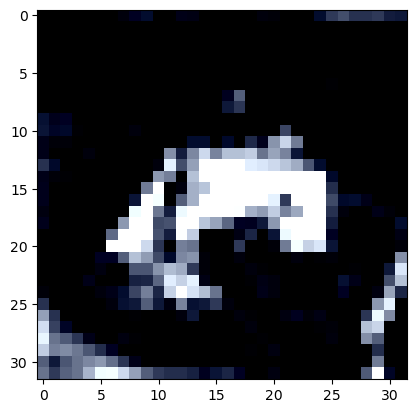

In [11]:
for (X_train, y_train) in train_loader:
    plt.imshow(X_train[0].permute(1,2,0).numpy())
    plt.show()
    break

## 4. torch.nn을 이용하여 모델-1 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Batch Normalization 을 사용할 것

In [12]:
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 3072)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

## 5. torch.nn을 이용하여 모델-2 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Dropout을 확률을 50%로 사용할 것 - BN는 사용하지 말것!

In [13]:
import torch.nn as nn

class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = x.view(-1, 3072)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [14]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500

    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        batch_size = image.shape[0]
        image = image.view(batch_size, -1)

        # Forward propagration 계산하기.
        outputs = network(image)
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(pred == label)

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct


In [15]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size(0)
            image = image.view(batch_size, -1)

            # Forward propagration 계산하기.
            outputs = network(image)

            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

             # Batch 별로 정확도 구하기
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy

## 7. 위 정의된 함수로 학습 함수 만들기

1. SGD Optimizer를 사용하고

2. Regularizer 를 사용하여 (weight_decay = 0.01로 사용할 것)

학습시키기

In [16]:
def training(network, learning_rate = 0.01):
    
#     learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.01)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [17]:
network = Model_1()
rlt_const = training(network, 0.01)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.389847
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.114059
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.112335
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.970672

Training set: Accuracy: 15783/50000 (32%)
Test set: Accuracy: 3581/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.031087
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.045955
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.037831
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.953761

Training set: Accuracy: 17770/50000 (36%)
Test set: Accuracy: 3808/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.943438
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.976479
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.993095
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.911431

Training set: Accuracy: 18481/50000 (37%)
Test set: Accuracy: 3910/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.918405
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.945996
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.998029
Train Epoch: 3 [48000/50000

In [24]:
network2 = Model_2()
rlt_const2 = training(network2, 0.005)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.397726
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.100903
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.122406
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.027854

Training set: Accuracy: 13287/50000 (27%)
Test set: Accuracy: 3355/10000 (34%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.058805
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.093129
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.116191
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.964858

Training set: Accuracy: 15643/50000 (31%)
Test set: Accuracy: 3612/10000 (36%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.928344
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.008949
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.025324
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.970778

Training set: Accuracy: 16443/50000 (33%)
Test set: Accuracy: 3721/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.996047
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.966334
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.040404
Train Epoch: 3 [48000/50000

# 8.학습 결과 보기 
## loss와 Accuracy 값 비교

In [19]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

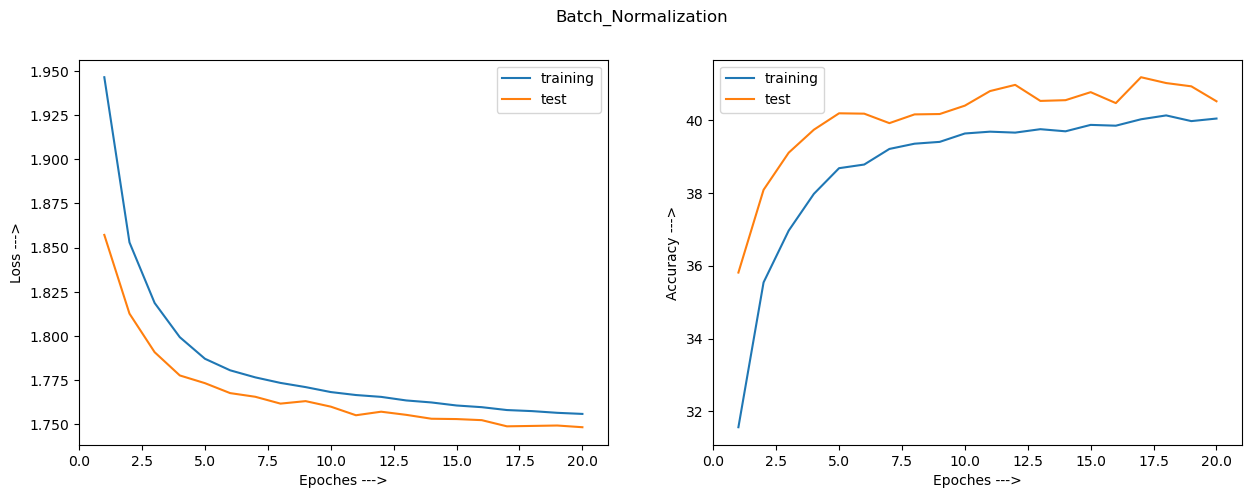

In [20]:
show_rlt(rlt_const, 'Batch_Normalization')

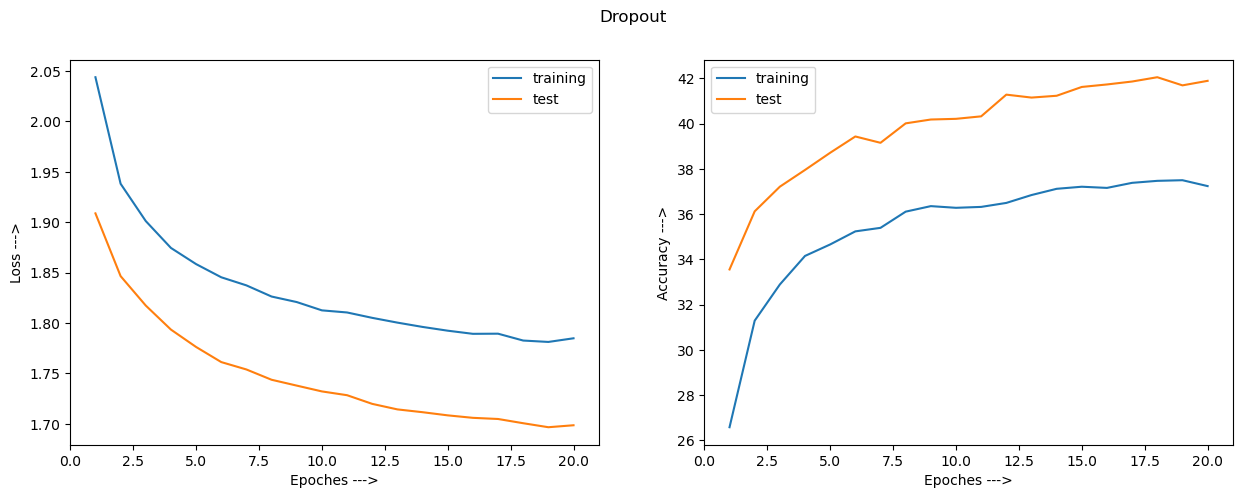

In [25]:
show_rlt(rlt_const2, 'Dropout')

# 9. Hyperparameter 찾기

위 Dropout 모델의 최적의 learning rate를 찾으세요.

스스로 계획을 짜고 어떤 lr 이 가장 나은 성능을 내었는지 분석하세요.

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.46E-03


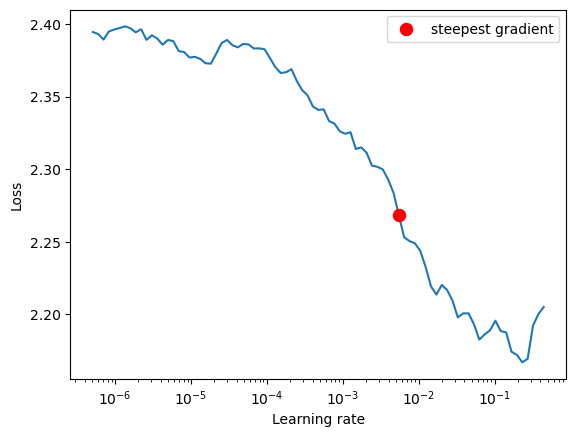

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.005462277217684344)

In [86]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Learning rate range test를 위한 모델 생성
network = Model_1()
cls_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=1e-7, momentum=0.9, weight_decay=0.01)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Learning rate range test를 실행
from torch_lr_finder import LRFinder

lr_finder = LRFinder(network, optimizer, cls_loss, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
lr_finder.plot(suggest_lr=True)



## 위에서 Suggested LR로 출력된 5.46E-03 == 0.00546이다.
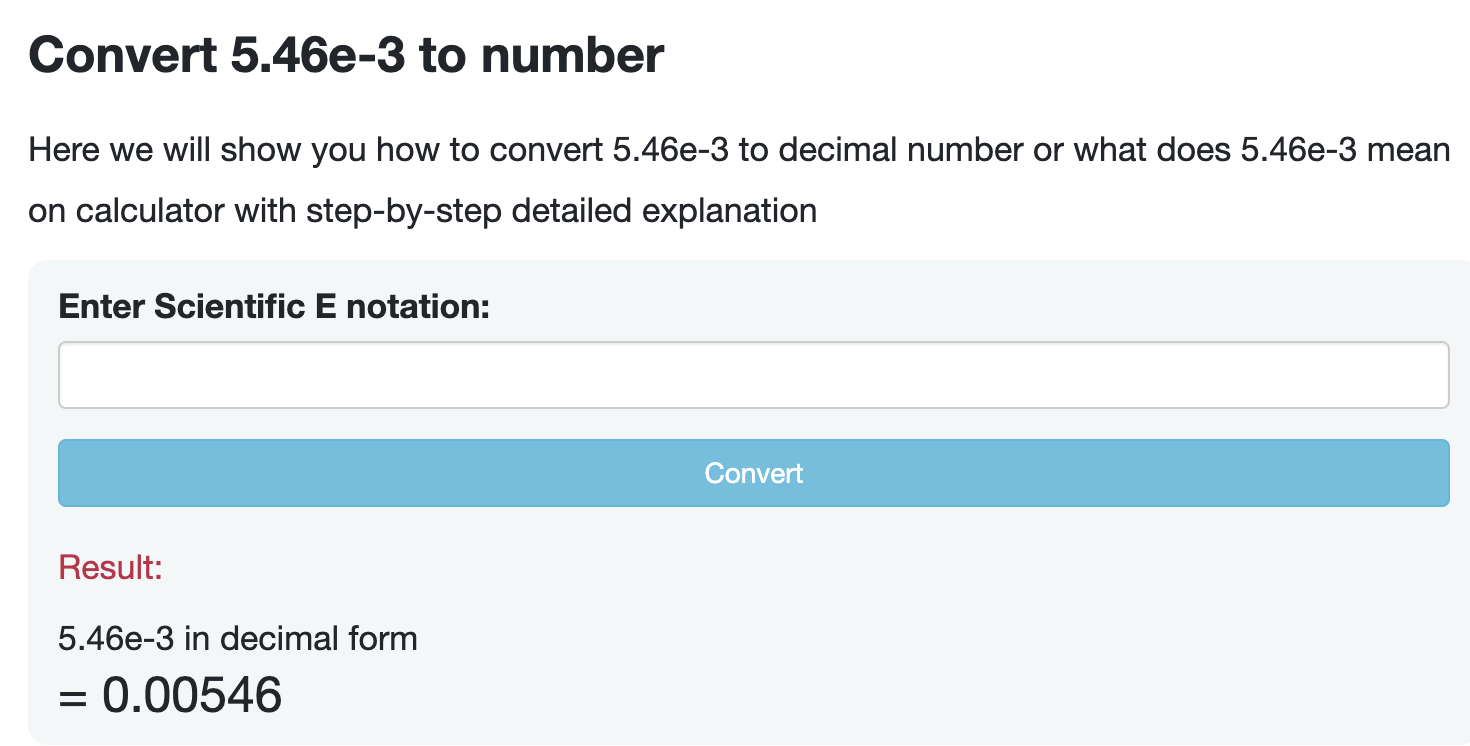
변환 사이트: https://calculator.name/scientific-notation-to-decimal/ <br>
최적의 learning rate는 0.00546이란 것을 알 수 있다.
### 기존의 lr인 0.05로 학습시킨 그래프
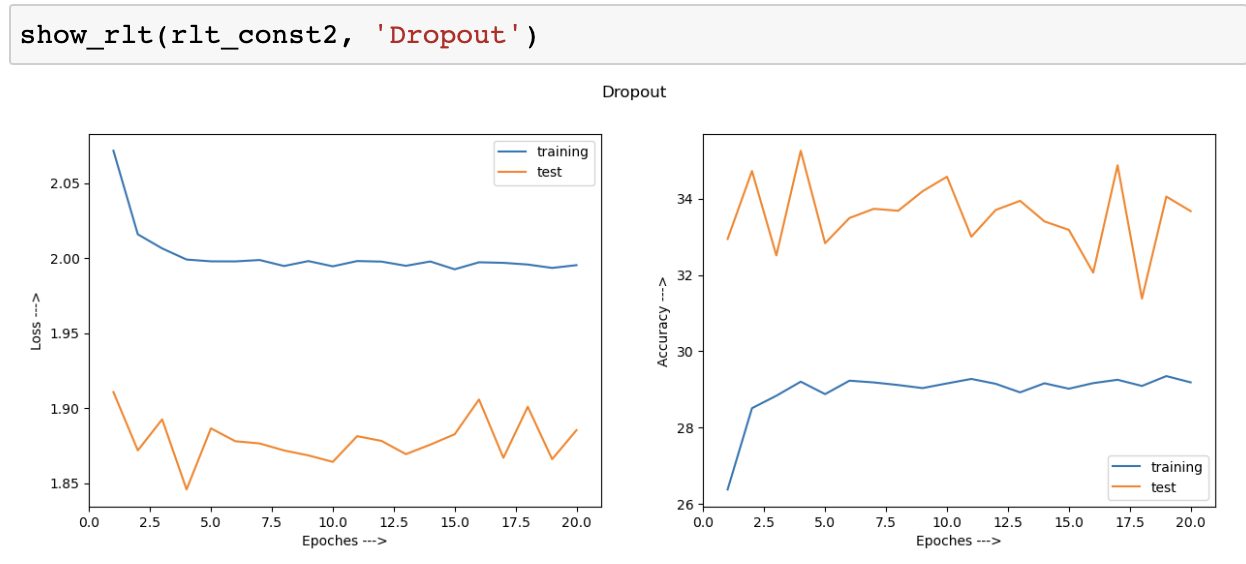
<br>
### 최적의 lr인 0.005로 학습시킨 그래프
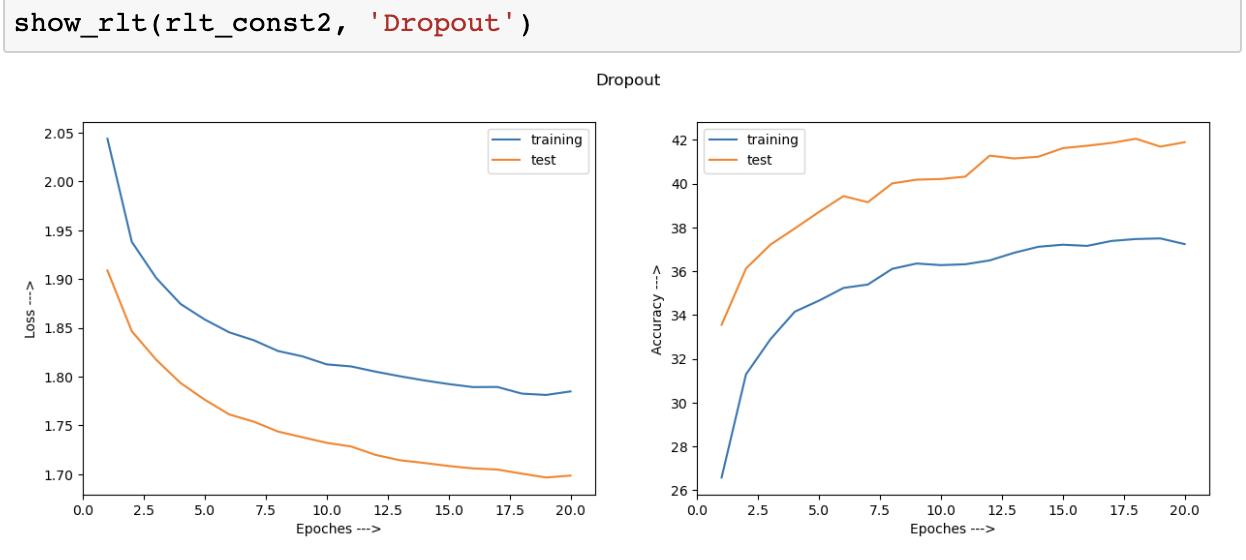
=> loss는 줄어들고 정확도는 높아지는 그래프로 바뀐 것을 확인할 수 있다.

In [52]:
print("2019125022 류재혁")

2019125022 류재혁
